In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
import tensorflow as tf
import keras
import os
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import evaluation_metrics

import keras.backend as K

Using TensorFlow backend.


In [5]:
def get_data(path):
    
    with open(path + 'scores.p', 'rb') as f:
        scores = pickle.load(f)

    with open(path + 'opt_params.p', 'rb') as f:
        opt_params = pickle.load(f)

    with open(path + 'acc_drop.p', 'rb') as f:
        acc_drop = pickle.load(f)

    return scores, opt_params, acc_drop

In [6]:
Results = collections.namedtuple('Results', 'scores, opt_params, acc_drop')

In [7]:
total_acc_drop = 0.005

# Accuracy drop

## Branched Network

In [2]:
global_save = 'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Final results/'
data_path = 'C:/Users/320060820/experiments/outputs/Comp_Dependent_Optimized_Search/'
models = os.listdir(data_path)

In [6]:
res = {}
for k in models:
    a, b, c = get_data(data_path + k + '/')
#     kk = k.split(' ')[1]
    res[k] = Results(scores = a, opt_params = b, acc_drop = c)

In [61]:
linear = lambda x, total_acc_drop, num_layers, offset=0: total_acc_drop/num_layers * x + offset

In [9]:
res['DF MNIST'].acc_drop

{'weights': {'conv2d_1': -0.0006117455138662775,
  'conv2d_5': -0.0006117455138662775,
  'conv2d_3': -0.00030587275693308213,
  'conv2d_8': 0.0008156606851549989,
  'conv2d_2': 0.0009176182707993596,
  'conv2d_6': 0.0012234910277324417,
  'conv2d_4': 0.0005097879282219168,
  'conv2d_7': 0.0005097879282219168,
  'conv2d_12': 0.001529363784665637,
  'conv2d_10': 0.00193719412724308,
  'conv2d_15': 0.0021411092985318013,
  'conv2d_9': 0.0024469820554648834,
  'conv2d_13': 0.0023450244698205226,
  'conv2d_11': 0.0025489396411093575,
  'conv2d_14': 0.0028548123980424397,
  'conv2d_19': 0.0013254486133768024,
  'conv2d_17': 0.002039151712887441,
  'conv2d_22': 0.00193719412724308,
  'conv2d_16': 0.0021411092985318013,
  'conv2d_20': 0.0031606851549755214,
  'conv2d_18': 0.002650897226753718,
  'conv2d_21': 0.0028548123980424397,
  'binary': 0.0034665579119086036},
 'biases': {'conv2d_1': 0.0031606851549755214,
  'conv2d_5': 0.002650897226753718,
  'conv2d_3': 0.002752854812398079,
  'conv2d_

In [11]:
for k in res:
    if k.startswith('DF'):
        print(k, res[k].acc_drop['activations']['binary'])
    else:
        print(k, res[k].acc_drop['activations']['dense_1'])
    

DF CIFAR10 0.009930220075147562
DF Fashion 0.009663957830002108
DF MNIST 0.00988988580750412
DF SVHN 0.00995791842006585
Sequential CIFAR10 0.0077641635326944946
Sequential Fashion 0.009084027252081716
Sequential MNIST 0.00984924623115581
Sequential SVHN 0.009779852698514871


In [62]:
def plot_seq_acc_drop(acc_drop, model):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    plt.figure(figsize=(12, 9))
    
    layer_names = list(acc_drop['weights'].keys())
    x = np.arange(1, len(layer_names) + 1, 1)
    
    y1 = linear(x, total_acc_drop, len(layer_names)) * 100
    y2 = linear(x, total_acc_drop, len(layer_names), total_acc_drop) * 100
    plt.plot(x, y1, marker='o', linestyle='--', color='tab:blue', label='Acceptable (Weights)');
    plt.plot(x, np.ones(y1.shape) * total_acc_drop * 100, marker='o', linestyle='--', color='tab:orange', 
             label='Acceptable (Biases)');
    plt.plot(x, y2, marker='o', linestyle='--', color='tab:green', label='Acceptable (Activations)');
    for j, k in enumerate(['weights', 'biases', 'activations']):
        y = np.array(list(acc_drop[k].values())) * 100
        plt.plot(x, y, 'o-', label= 'Measured ' + '(' + k.capitalize() + ')')

    plt.grid(b=True)
    plt.legend()
    layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]
    plt.xticks(x, layer_names, rotation='vertical')
    plt.xlabel('Layer name')
    plt.ylabel('Inference Accuracy Loss (%)')
    model = model.split(' ')[0] + '_' + model.split(' ')[1]
    plt.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Final results/' \
                + 'opts_seq_acc_loss_' + model + '.png', bbox_inches='tight')
    

In [63]:
def plot_bw(opt_params, model, width=0.9):

    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if model.startswith('Sequential'):
        plt.figure(figsize=(12, 9))
    else:
        plt.figure(figsize=(15, 7))

    x = np.arange(1, 3.5*len(list(opt_params['weights'].keys())) + 1, 3.5)
    for j, k in enumerate(['weights', 'biases', 'activations']):
        bw = [opt_params[k][layer][0] for layer in opt_params[k]]
        plt.bar([i + j*width for i in x], bw, width, label=k)

    layer_names = list(opt_params['weights'].keys())
    layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names]
    plt.xticks(x + width*1.5, layer_names, rotation='horizontal')
    plt.grid()
    plt.legend()
    plt.xlabel('Layer name')
    plt.ylabel('Bitwidth (bits)')
    model = model.split(' ')[0] + '_' + model.split(' ')[1]
    plt.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Final results/' \
                + 'opts_bw_' + model + '.png', 
                bbox_inches='tight')

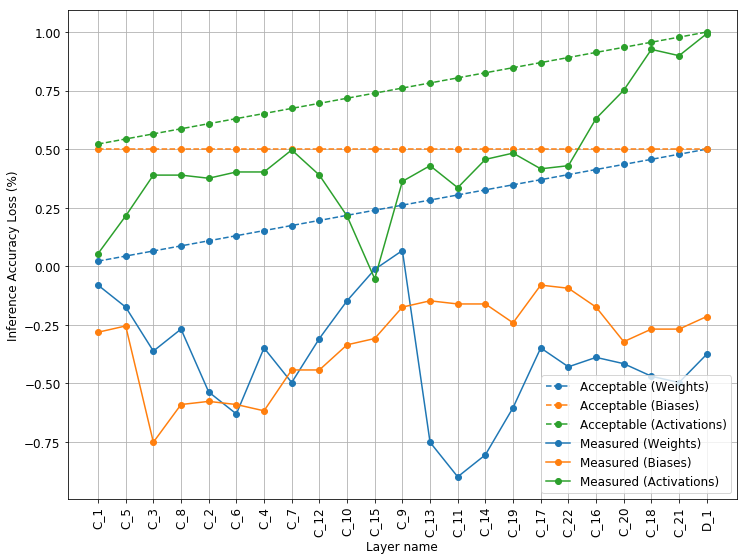

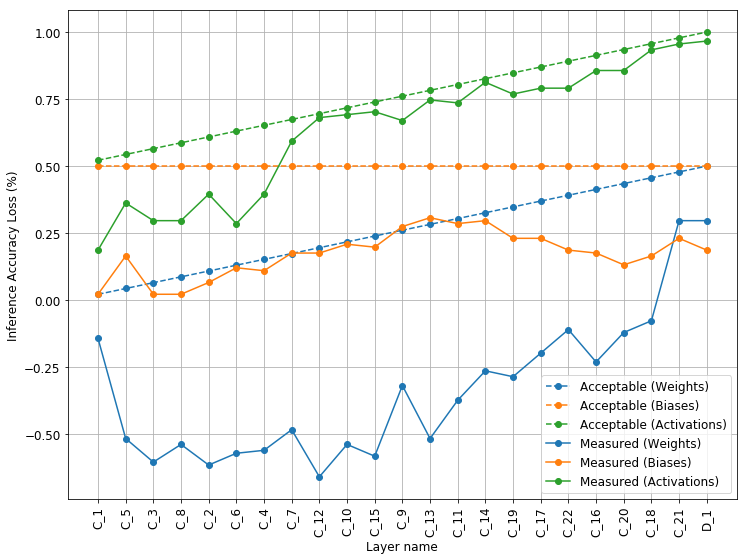

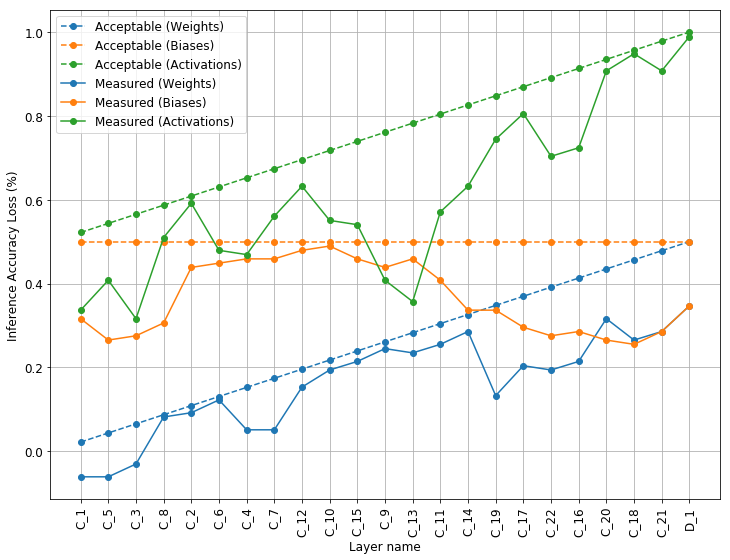

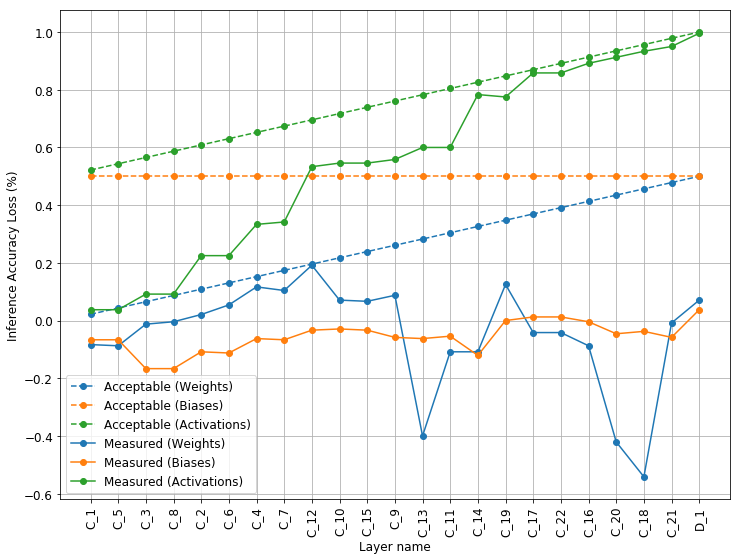

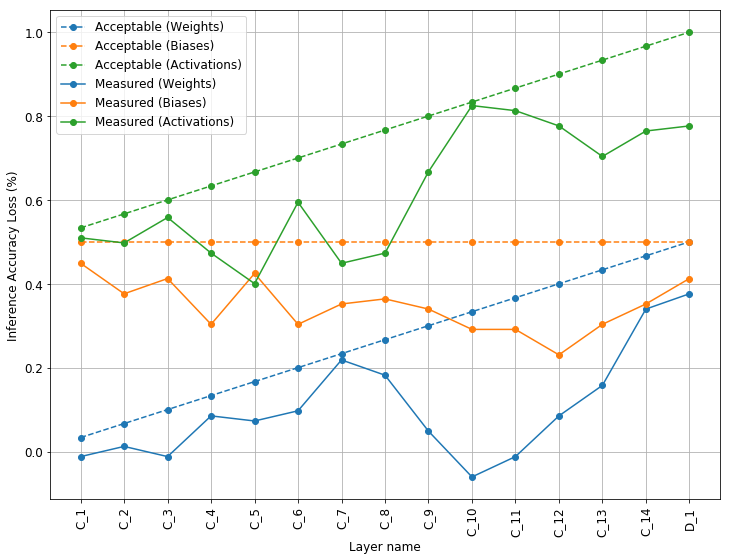

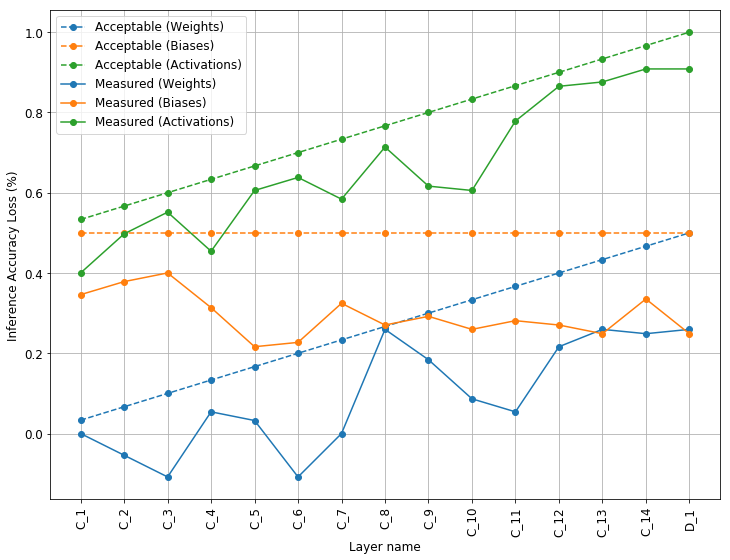

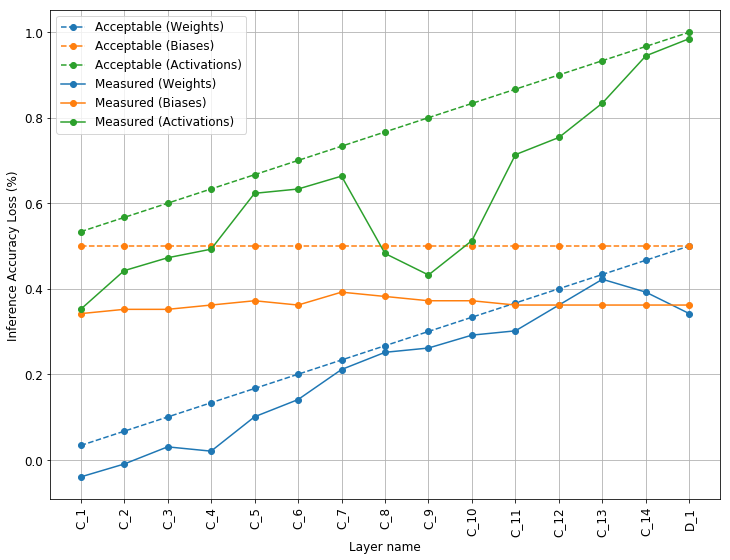

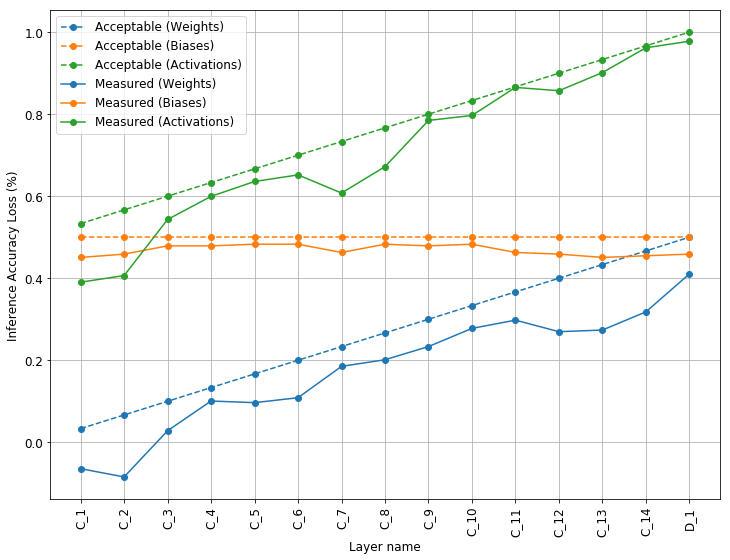

In [12]:
for m in models:
    plot_seq_acc_drop(res[m].acc_drop, m)

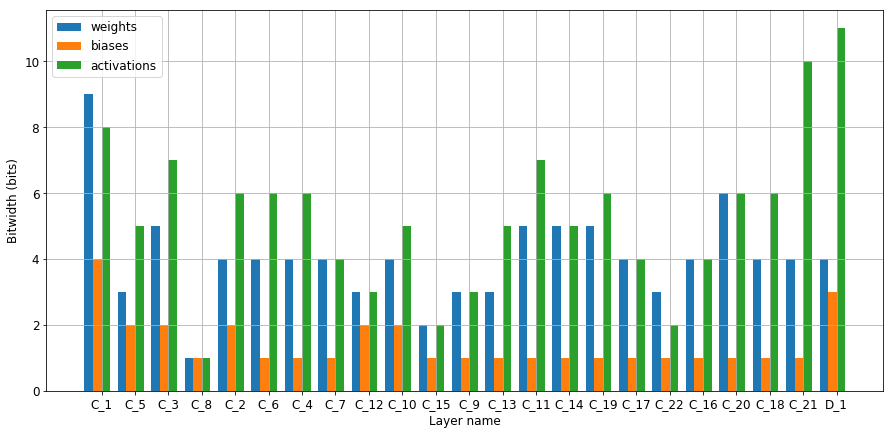

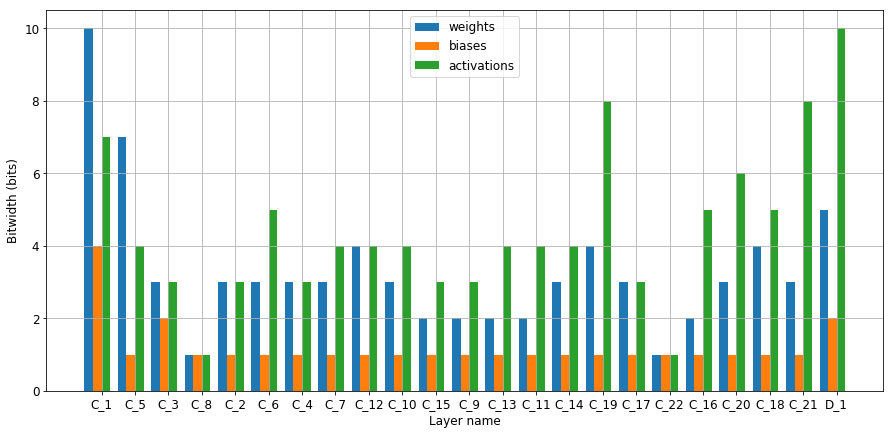

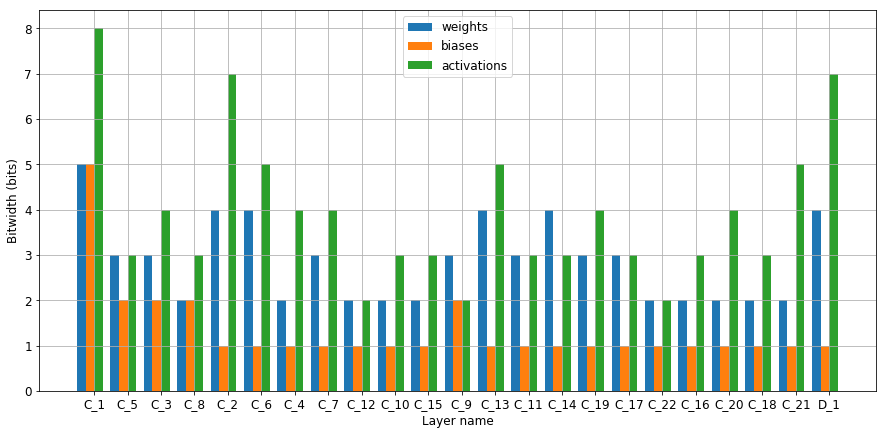

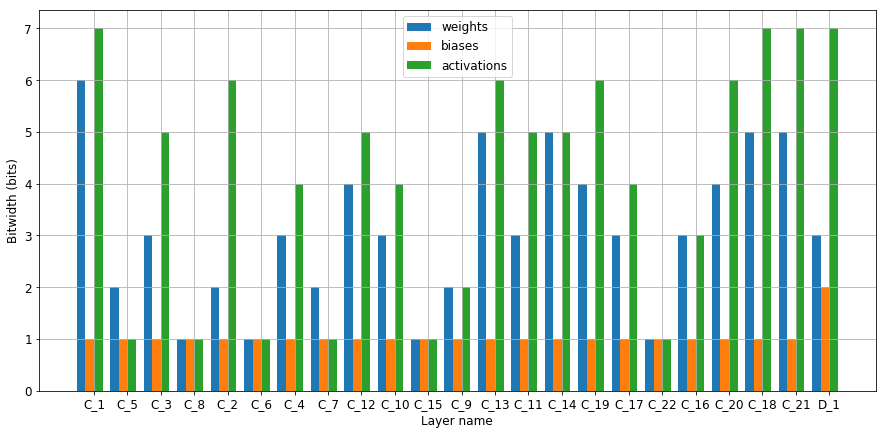

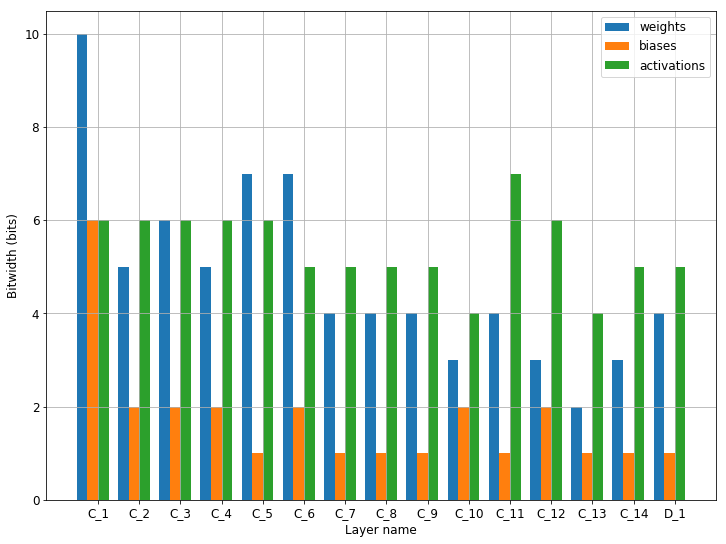

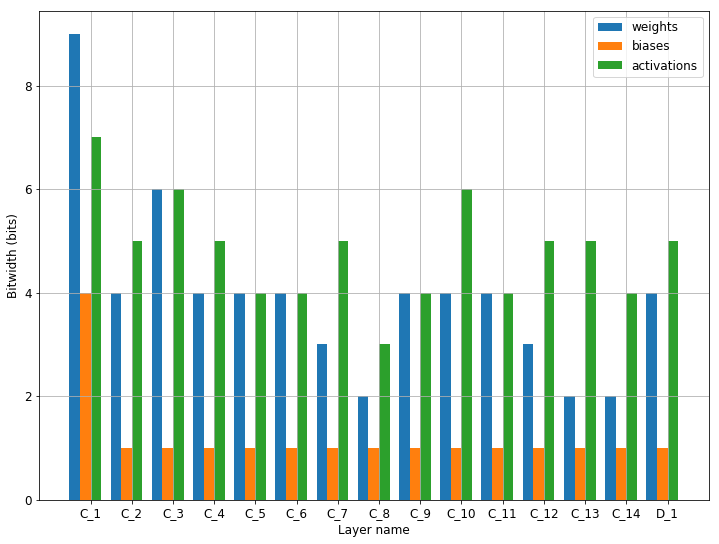

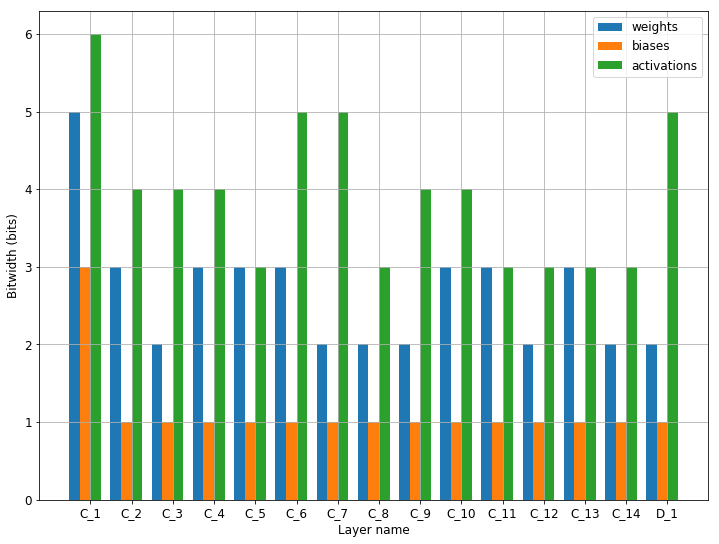

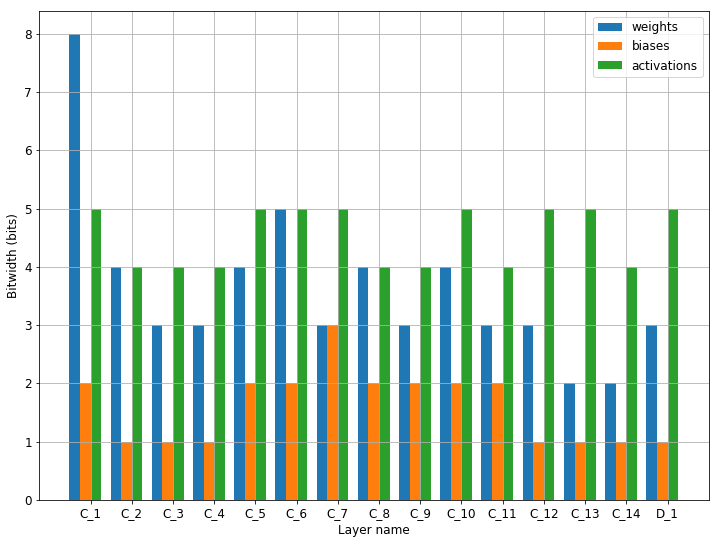

In [65]:
for m in models:
    plot_bw(res[m].opt_params, m)

# Memory Consumption

In [8]:
models = ['Sequential MNIST', 'Sequential CIFAR10', 'Sequential Fashion', 'Sequential SVHN']
models = models + ['DF MNIST', 'DF CIFAR10', 'DF Fashion', 'DF SVHN']
res = {}
for k in models:
    a, b, c = get_data(data_path + k + '/')
    if k.startswith('DF'):
        kk = 'Branched ' + k.split(' ')[1]
    else:
        kk = k
    res[kk] = Results(scores = a, opt_params = b, acc_drop = c)

In [9]:
model_path = {'Branched CIFAR10': 'C:/Users/320060820/experiments/test_models/cifar_df2/model_32_0.75.h5',
              'Branched Fashion': 'C:/Users/320060820/experiments/test_models/fashion_df/fashion_df.h5',
              'Branched MNIST': 'C:/Users/320060820/experiments/test_models/mnist_df/inception_v3_model_batchnorm.h5',
              'Branched SVHN': 'C:/Users/320060820/experiments/test_models/svhn_df/svhn_df.h5',
              'Sequential CIFAR10': 'C:/Users/320060820/experiments/test_models/cifar_keras/cifar_seq_large.h5',
              'Sequential MNIST': 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large.h5',
              'Sequential Fashion': 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large.h5',
              'Sequential SVHN': 'C:/Users/320060820/experiments/test_models/svhn_keras/svhn_seq_large.h5'}

In [10]:
memory_consumption = {}
for k in res:
    layer_names = list(res[k].acc_drop['weights'].keys())
    K.clear_session()
    model = keras.models.load_model(model_path[k])
    memory_consumption[k] = evaluation_metrics.evaluate_memory_consumption(model, layer_names, 
                                                                           res[k].opt_params)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
for k in memory_consumption:
    print(k, sum(list(memory_consumption[k].values())))

Sequential MNIST 166.66748046875
Sequential CIFAR10 271.50732421875
Sequential Fashion 211.71044921875
Sequential SVHN 218.35498046875
Branched MNIST 206.2763671875
Branched CIFAR10 278.4482421875
Branched Fashion 207.935546875
Branched SVHN 212.668701171875


In [13]:
def fixed_bitwidth_memory(model, layer_names, bitwidth):
    
    num_weights, num_biases = model_data.get_num_params_per_layer(model, layer_names)
    num_activations = model_data.get_num_activations_per_layer(model, layer_names)
    num_params = {'weights': num_weights, 'biases': num_biases, 'activations': num_activations}
    
    mem_cons = {}
    for k in num_params:
        mem_cons[k] = sum([bitwidth * num_params[k][i] for i in range(len(layer_names))]) / (8*1024)
    
    return mem_cons

In [14]:
fixed_bw_mem8 = {}
for k in res:
    layer_names = list(res[k].acc_drop['weights'].keys())
    K.clear_session()
    model = keras.models.load_model(model_path[k])
    fixed_bw_mem8[k] = fixed_bitwidth_memory(model, layer_names, 8)

In [15]:
fixed_bw_mem32 = {}
for k in res:
    layer_names = list(res[k].acc_drop['weights'].keys())
    K.clear_session()
    model = keras.models.load_model(model_path[k])
    fixed_bw_mem32[k] = fixed_bitwidth_memory(model, layer_names, 32)

In [28]:
val32 = []
val8 = []
for k in memory_consumption:
    mem = sum(list(memory_consumption[k].values()))
    f8 = sum(list(fixed_bw_mem8[k].values()))
    f32 = sum(list(fixed_bw_mem32[k].values()))
    print('32-bit to opts', k, (f32 - mem)/f32 * 100)
    print('32-bit to 8-bit', k, (f32 - f8)/f32 * 100)
    print('8-bit to opts', k, (f8 - mem)/f8 * 100)
    print('------------')
    val32.append((f32 - mem)/f32 * 100)
    val8.append((f8 - mem)/f8 * 100)
print(np.mean(np.array(val32)))
print(np.mean(np.array(val8)))

32-bit to opts Sequential MNIST 90.67961138538162
32-bit to 8-bit Sequential MNIST 75.0
8-bit to opts Sequential MNIST 62.7184455415265
------------
32-bit to opts Sequential CIFAR10 86.14371934930824
32-bit to 8-bit Sequential CIFAR10 75.0
8-bit to opts Sequential CIFAR10 44.57487739723297
------------
32-bit to opts Sequential Fashion 88.16071584603958
32-bit to 8-bit Sequential Fashion 75.0
8-bit to opts Sequential Fashion 52.64286338415833
------------
32-bit to opts Sequential SVHN 88.85633048921494
32-bit to 8-bit Sequential SVHN 75.0
8-bit to opts Sequential SVHN 55.425321956859776
------------
32-bit to opts Branched MNIST 89.33377972222895
32-bit to 8-bit Branched MNIST 75.0
8-bit to opts Branched MNIST 57.33511888891583
------------
32-bit to opts Branched CIFAR10 85.61234973074656
32-bit to 8-bit Branched CIFAR10 75.0
8-bit to opts Branched CIFAR10 42.449398922986255
------------
32-bit to opts Branched Fashion 89.24798620032156
32-bit to 8-bit Branched Fashion 75.0
8-bit to

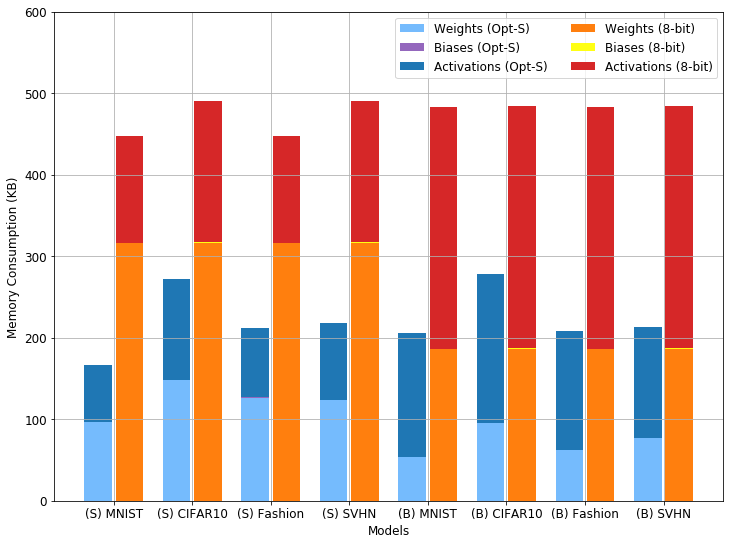

In [26]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
x1 = np.arange(1, 9, 1)
width = 0.35
x2 = x1 + width + 0.05
x3 = x1 + width*2 + 0.1
plt.figure(figsize=(12, 9))
w_values = np.array([memory_consumption[k]['weights'] for k in memory_consumption])
b_values = np.array([memory_consumption[k]['biases'] for k in memory_consumption])
a_values = np.array([memory_consumption[k]['activations'] for k in memory_consumption])

p1 = plt.bar(x1, w_values, width, color='xkcd:sky blue')
p2 = plt.bar(x1, b_values, width, bottom=w_values.tolist(), color='tab:purple')
p3 = plt.bar(x1, a_values, width, bottom=np.add(w_values, b_values).tolist(), color='tab:blue')

w_values = np.array([fixed_bw_mem8[k]['weights'] for k in fixed_bw_mem8])
b_values = np.array([fixed_bw_mem8[k]['biases'] for k in fixed_bw_mem8])
a_values = np.array([fixed_bw_mem8[k]['activations'] for k in fixed_bw_mem8])

p4 = plt.bar(x2, w_values, width, color='tab:orange')
p5 = plt.bar(x2, b_values, width, bottom=w_values.tolist(), color='xkcd:yellow')
p6 = plt.bar(x2, a_values, width, bottom=np.add(w_values, b_values).tolist(), color='tab:red')

x3 = x1 + (width + 0.05) / 2
lab = list(memory_consumption.keys())
lab = [('(S) ' + x.split(' ')[1]) if x.startswith('Sequential') else ('(B) ' + x.split(' ')[1]) for x in lab]

plt.xticks(x3, lab)

plt.legend([p1[0], p2[0], p3[0], p4[0], p5[0], p6[0]],
           ['Weights (Opt-S)', 'Biases (Opt-S)', 'Activations (Opt-S)', 
            'Weights (8-bit)', 'Biases (8-bit)', 'Activations (8-bit)'], ncol=2)
#             'Weights (4-bit)', 'Biases (4-bit)', 'Activations (4-bit)'], ncol=3)
plt.ylim(0, 600)
plt.grid();
plt.xlabel('Models')
plt.ylabel('Memory Consumption (KB)')
plt.savefig(global_save + 'mem_consumption.png', bbox_inches='tight')

In [20]:
def get_num_activations_per_layer(model, layer_names, exclude_kernels=False):

    num_activations = []
    for layer in model.layers:
        if layer.name in layer_names:
            if exclude_kernels:
                num_activations.append(np.product(layer.output_shape[1:-1]))
            else:
                num_activations.append(np.product(layer.output_shape[1:]))
    
    return num_activations

In [21]:
def evaluate_multiplications_cost(model, layer_names, quant_params):

    num_weights, _ = model_data.get_num_params_per_layer(model, layer_names)
    num_activations = get_num_activations_per_layer(model, layer_names, exclude_kernels=True)

    cost = []

    for i in range(len(layer_names)):
        bw_w = quant_params['weights'][layer_names[i]][0]
        bw_a = quant_params['activations'][layer_names[i]][0]
        cost.append((bw_w * num_weights[i] * bw_a * num_activations[i]))
    
    return sum(cost)

In [22]:
mult_cost = {}
for k in res:
    K.clear_session()
    model = keras.models.load_model(model_path[k])
    layer_names = list(res[k].acc_drop['weights'].keys())
    mult_cost[k] = evaluate_multiplications_cost(model, layer_names, res[k].opt_params)

In [23]:
def mult_cost_fixed_bw(model, layer_names, bitwidth=8):

    num_weights, _ = model_data.get_num_params_per_layer(model, layer_names)
    num_activations = get_num_activations_per_layer(model, layer_names, exclude_kernels=True)

    cost = []

    for i in range(len(layer_names)):
        cost.append(np.uint64(bitwidth * num_weights[i] * bitwidth * num_activations[i]))
    
    return sum(cost)

In [24]:
mult_cost_fixedbw8 = {}
for k in res:
    K.clear_session()
    model = keras.models.load_model(model_path[k])
    layer_names = list(res[k].acc_drop['weights'].keys())
    mult_cost_fixedbw8[k] = mult_cost_fixed_bw(model, layer_names, 8)

In [27]:
val = []
for k in mult_cost:
    v = (mult_cost_fixedbw8[k] - mult_cost[k])/mult_cost_fixedbw8[k] * 100
    print(k, v)
    val.append(v)
print(np.mean(np.array(val)))

Sequential MNIST 84.93777169537915
Sequential CIFAR10 57.173796195862714
Sequential Fashion 70.18224219127355
Sequential SVHN 76.32814996828272
Branched MNIST 87.066131712227
Branched CIFAR10 75.42759418168227
Branched Fashion 85.22556158233611
Branched SVHN 83.82352225475385
77.52059622272466


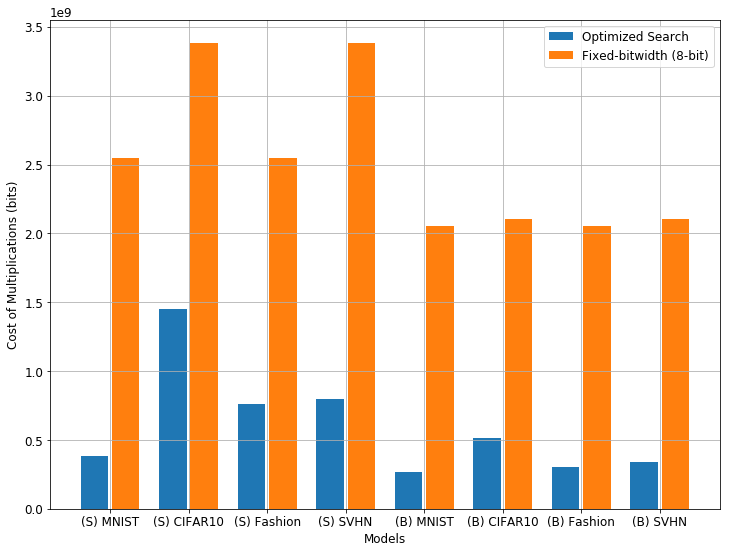

In [27]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
x1 = np.arange(1, 9, 1)
width = 0.35
x2 = x1 + width + 0.05
plt.figure(figsize=(12, 9))

plt.bar(x1, mult_cost.values(), width, label='Optimized Search');
plt.bar(x2, mult_cost_fixedbw8.values(), width, label='Fixed-bitwidth (8-bit)')

x4 = x1 + (width + 0.05)/2
lab = list(mult_cost.keys())
lab = [('(S) ' + x.split(' ')[1]) if x.startswith('Sequential') else ('(B) ' + x.split(' ')[1]) for x in lab]
plt.xticks(x4, lab)

plt.legend()
plt.grid()
plt.xlabel('Models')
plt.ylabel('Cost of Multiplications (bits)')
plt.savefig(global_save + 'mult_cost.png', bbox_inches='tight')